In [33]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
import json

In [2]:
contents = pd.read_csv('../data/newsContents.csv')

In [3]:
print (contents.shape)
contents.head(3)

(8041759, 3)


,href,actor,content
0,http://news.naver.com/main/read.nhn?mode=LSD&m...,BoA,- FRB 유동성 공급에 4개 중앙銀 동참 - `슈퍼펀드` 조성에 日 금융권 지원할...
1,http://news.naver.com/main/read.nhn?mode=LSD&m...,BoA,- BOA 최고경영자 경고[이데일리 권소현기자] 뱅크 오브 아메리카(BOA)의 켄 ...
2,http://news.naver.com/main/read.nhn?mode=LSD&m...,BoA,- 국제신용등급 어드바이저로 골드만삭스·BOA 선정- 2억불 외화채권 발행 추진…미...


In [4]:
titles = pd.read_csv('../data/newsTitle.csv')

In [5]:
print (titles.shape)
titles.head(3)

(23367091, 6)


,href_origin,title,actor,time,href_naver,press
0,http://news.naver.com/main/read.nhn?mode=LSD&m...,深層취재,BoA,1990.07.07,http://news.naver.com/main/read.nhn?mode=LSD&m...,연합뉴스
1,http://news.naver.com/main/read.nhn?mode=LSD&m...,걸프 장기전 경우 유가 2월에 40-50달러,BoA,1991.01.25,http://news.naver.com/main/read.nhn?mode=LSD&m...,연합뉴스
2,http://news.naver.com/main/read.nhn?mode=LSD&m...,18개 국내은행 세계 5백대은행에 랭크,BoA,1991.08.09,http://news.naver.com/main/read.nhn?mode=LSD&m...,연합뉴스


In [47]:
synopses = []
for synopse in contents.content.values[:1000]:
    if synopse != synopse:
        synopses.append("")
    else:
        synopses.append(synopse)

In [48]:
titles = [ synopse[:32] for synopse in synopses ]

In [37]:
stopwords = json.load(open('../../namuGrim/data/stopwords-ko.json', 'r'))

In [68]:
from konlpy.tag import Twitter
tagger = Twitter()

def tokenize(text):
    return tagger.morphs(text)

stoptags = ['KoreanParticle', 'PreEomi', 'Punctuation', 'Eomi', 'Number', 'Foreign', 'URL']
def stemize(text):
    return [ word for word, tag in tagger.pos(text) if not tag in stoptags]

def tagging(text):
    return [ "{}/{}".format(word, tag) for word, tag in tagger.pos(text) if not tag in stoptags]

def steamToken(text):
    return 

In [95]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in synopses:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [107]:
vocab_stemmed = []
vocab_tokenize = []
for vocabs in [stemize(synopse) for synopse in synopses]:
    vocab_stemmed.extend(vocabs)
for vocabs in [tokenize(synopse) for synopse in synopses ]:
    vocab_tokenize.extend(vocabs)

In [109]:
vocab_frame = pd.DataFrame({'words': vocab_stemmed}, index = vocab_stemmed)
print ('there are ' + str(vocab_frame.shape[0]) + ' items in vocab')

there are 498837 items in vocab


In [110]:
vocab_frame.head()

,words
FRB,FRB
유동성,유동성
공급,공급
에,에
개,개


## TODO
- eng to kor
- except pre-define counter 
- variable plot visualize

In [111]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=stemize, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(synopses) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

CPU times: user 21.7 s, sys: 56 ms, total: 21.8 s
Wall time: 21.9 s
(1000, 315)


In [112]:
terms = tfidf_vectorizer.get_feature_names()

In [113]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)
print (dist)

[[  1.11022302e-16   6.89751440e-01   6.32873845e-01 ...,   7.79795723e-01
    7.15228449e-01   7.55310814e-01]
 [  6.89751440e-01   0.00000000e+00   5.86126537e-01 ...,   7.79698692e-01
    8.62924613e-01   7.61666740e-01]
 [  6.32873845e-01   5.86126537e-01  -2.22044605e-16 ...,   8.04192583e-01
    8.25617161e-01   8.20167534e-01]
 ..., 
 [  7.79795723e-01   7.79698692e-01   8.04192583e-01 ...,   0.00000000e+00
    4.45026611e-01   2.34096993e-01]
 [  7.15228449e-01   8.62924613e-01   8.25617161e-01 ...,   4.45026611e-01
   -2.22044605e-16   4.38965579e-01]
 [  7.55310814e-01   7.61666740e-01   8.20167534e-01 ...,   2.34096993e-01
    4.38965579e-01  -2.22044605e-16]]


In [114]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 8.51 s, sys: 24 ms, total: 8.54 s
Wall time: 9.07 s


In [118]:
films = { 'title': titles, 'synopsis': synopses, 'cluster': clusters }
frame = pd.DataFrame(films, index = [clusters] , columns = ['title', 'cluster'])

In [121]:
frame['cluster'].value_counts()

1    349
2    268
0    211
4    153
3     19
Name: cluster, dtype: int64

## TODO
- MDS config
- plt detail visualize
- save to output

In [125]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

In [126]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'Family, home, war', 
                 1: 'Police, killed, murders', 
                 2: 'Father, New York, brothers', 
                 3: 'Dance, singing, love', 
                 4: 'Killed, soldiers, captain'}

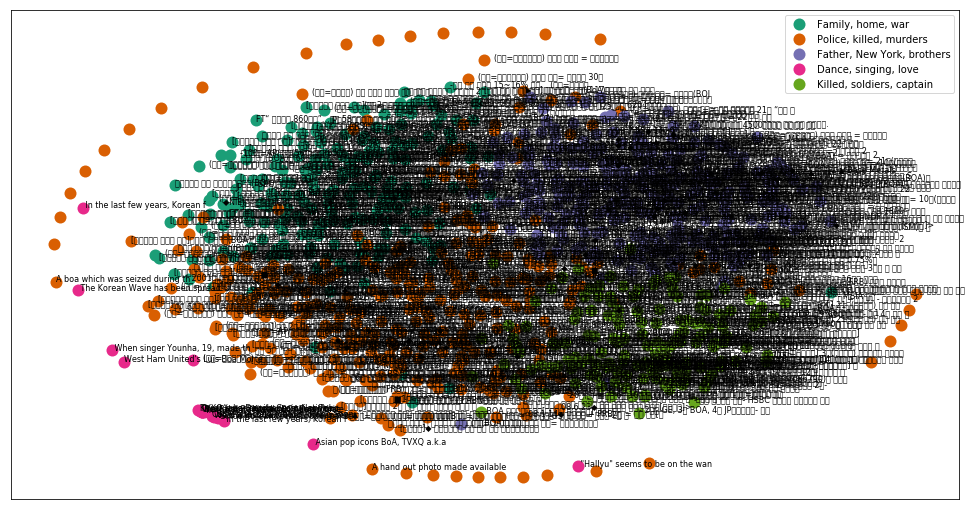

In [127]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

In [128]:
plt.close()

In [129]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [130]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, 
                     label=cluster_names[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1)

mpld3.display()

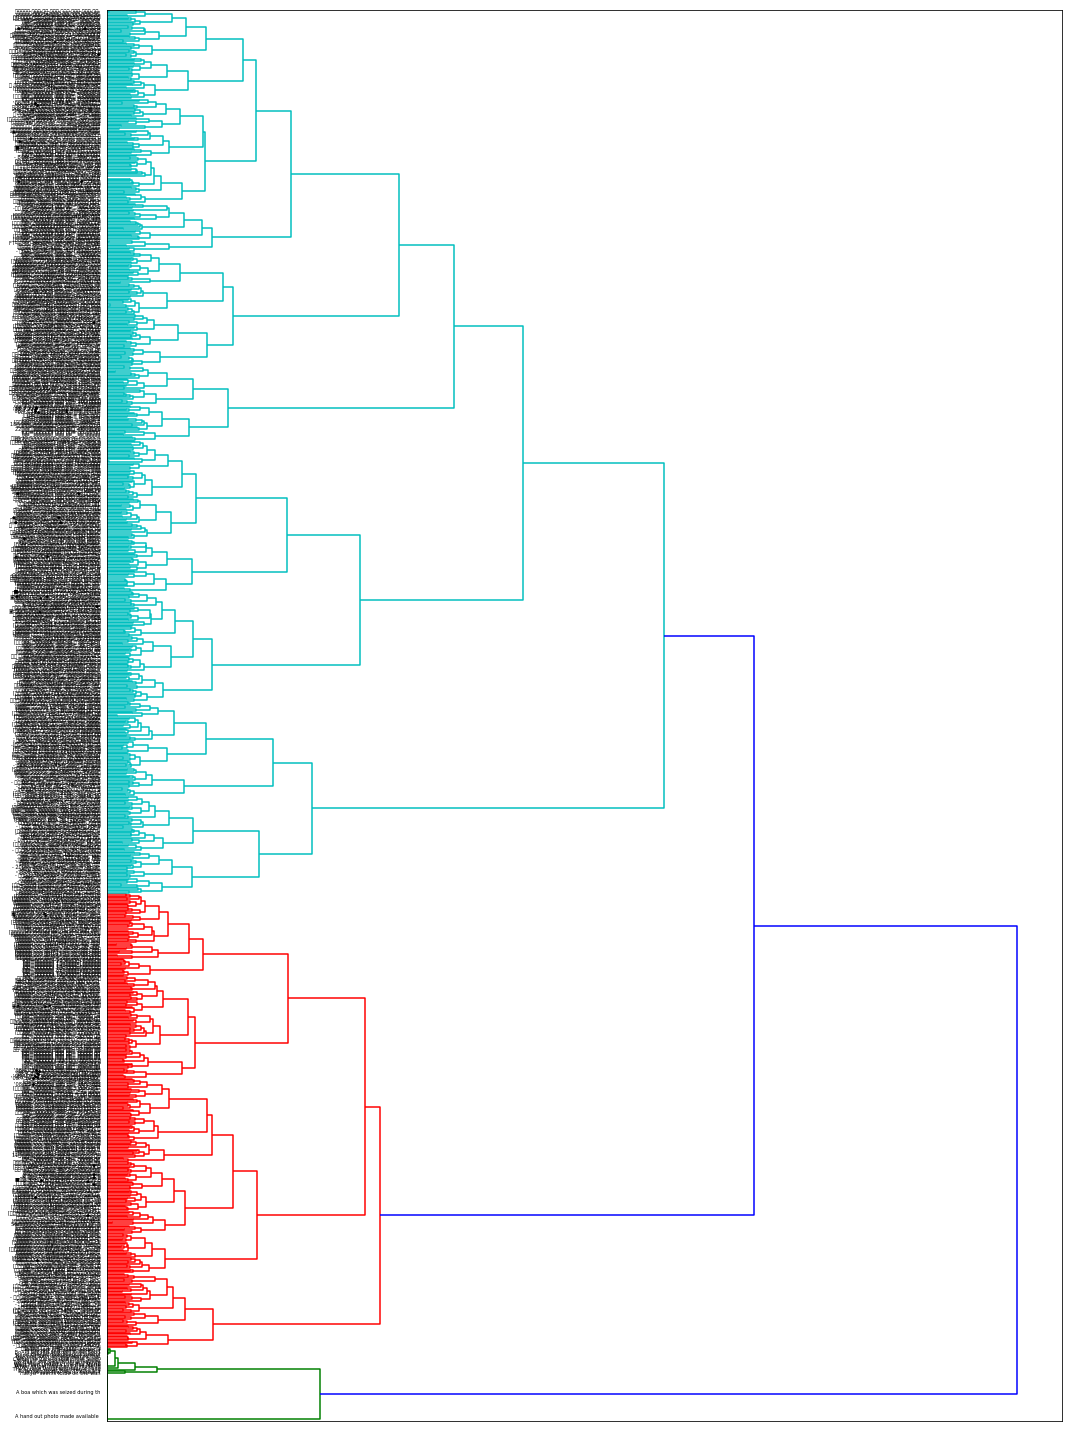

In [131]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

In [132]:
plt.close()

In [133]:

#strip any proper names from a text...unfortunately right now this is yanking the first word from a sentence too.
import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

In [134]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [135]:
from gensim import corpora, models, similarities 

#remove proper names
%time preprocess = [strip_proppers(doc) for doc in synopses]

#tokenize
%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]

#remove stop words
%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

CPU times: user 2.55 s, sys: 32 ms, total: 2.58 s
Wall time: 3.19 s
CPU times: user 268 ms, sys: 0 ns, total: 268 ms
Wall time: 271 ms
CPU times: user 96 ms, sys: 0 ns, total: 96 ms
Wall time: 93.9 ms


In [136]:
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.8)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]

In [138]:
%time lda = models.LdaModel(corpus, num_topics=5,id2word=dictionary,update_every=5,chunksize=10000,passes=100)

CPU times: user 1min 15s, sys: 44 ms, total: 1min 15s
Wall time: 1min 16s


In [139]:
lda.show_topics()

[(0,
  '0.138*"http" + 0.124*"//www.edaily.co.kr＞＜안방에서" + 0.030*"sljun" + 0.029*"recess" + 0.026*"s914" + 0.017*"bstar" + 0.017*"jmoon" + 0.014*"25bp" + 0.013*"50bp" + 0.013*"kennyb"'),
 (1,
  '0.037*"yna.co.kr" + 0.036*"asiaeconomy.co.kr" + 0.028*"www.asiaeconomy.co.kr" + 0.023*"everwhit" + 0.021*"p" + 0.019*"smjeong" + 0.017*"hugh" + 0.011*"sed.co.krⓒ" + 0.008*"nut" + 0.007*"www.hankooki.com"'),
 (2,
  '0.059*"www.asiae.co.kr" + 0.033*"onlyyou" + 0.017*"donga.com" + 0.015*"ez-iⓒ" + 0.015*"매직n" + 0.012*"donga.com내" + 0.011*"donkim" + 0.010*"psm82" + 0.007*"hjlee303" + 0.007*"nut"'),
 (3,
  '0.067*"the" + 0.041*"of" + 0.037*"in" + 0.033*"and" + 0.028*"to" + 0.022*"a" + 0.013*"as" + 0.012*"is" + 0.009*"with" + 0.008*"film"'),
 (4,
  '0.121*"yna.co.kr" + 0.049*"sgyoo" + 0.020*"hjlee2" + 0.016*"kyr" + 0.014*"sed.co.krⓒ" + 0.013*"heraldbiz.com" + 0.013*"kism" + 0.012*"heraldm.com" + 0.010*"jang73" + 0.010*"hyle"')]